<a href="https://colab.research.google.com/github/jnmaloof/DeepLearning_JulinMaloof/blob/main/Flowers_R_Kefras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Colab notebook for trying to classify flowers

In [2]:
install.packages("googledrive")
library("googledrive")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# Check if is running in Colab and redefine is_interactive()
if (file.exists("/usr/local/lib/python3.7/dist-packages/google/colab/_ipython.py")) {
  install.packages("R.utils")
  library("R.utils")
  library("httr")
  my_check <- function() {return(TRUE)}
  reassignInPackage("is_interactive", pkgName = "httr", my_check) 
  options(rlang_interactive=TRUE)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.10.1 (2020-08-26 22:50:31 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings




In [4]:
drive_auth(use_oob = TRUE, cache = TRUE)


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AY0e-g5aaWy40Kc7F1kRqMqCd_n7ApCd6cU7vSx-18V8yyUGF2jDFyCpWmk


In [5]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’




In [19]:
library(keras)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks R.utils::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()



In [16]:
utils::unzip("newFlowers.zip")

In [17]:
flowers <- dir(path = "newFlowers")
flowers

[1] "daisy"     "dandelion" "rose"      "sunflower" "tulip"

In [28]:
#tmp as a holder for the T/F that come out of these

tmp <- if(dir.exists("train")) file.remove(dir(path = "train/", full.names = TRUE, recursive = TRUE))
tmp <- if(dir.exists("test")) file.remove(dir(path = "test/", full.names = TRUE, recursive = TRUE))
tmp <- if(dir.exists("validation")) file.remove(dir(path = "validation/", full.names = TRUE, recursive = TRUE))

tmp <- if(!dir.exists("train")) dir.create("train/")
tmp <- if(!dir.exists("test")) dir.create("test/")
tmp <- if(!dir.exists("validation")) dir.create("validation/")

tmp <- map(flowers, ~ if(!dir.exists(file.path("train", .x)))
                  dir.create(file.path("train", .x ))
                  )
    
tmp <- map(flowers, ~ if(!dir.exists(file.path("test", .x)))
                  dir.create(file.path("test", .x ))
                  )
    
tmp <- map(flowers, ~ if(!dir.exists(file.path("validation", .x)))
                  dir.create(file.path("validation", .x ))
                  )



logical(0)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [15] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [29] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [43] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [57] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [71] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [85] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
  [99] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [113] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [127] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [141] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [155] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [169] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [183] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [197] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [225] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [239] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [253] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [267] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [281] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [295] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [309] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [323] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [337] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [351] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [365] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [379] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [393] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [407] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [435] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [449] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [463] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [477] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [491] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [505] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [519] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [533] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [547] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [561] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [575] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [589] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [603] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [617] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [631] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [645] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [659] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [673] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [687] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [701] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [715] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
 [91] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[106] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[121] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[136] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[151] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[166] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[181] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[196] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[211] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[226] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[241] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[256] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[271] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[286] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[301] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[316] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[331] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[346] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[361] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[376] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[391] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[406] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[421] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[436] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[451] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[466] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[481] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[496] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[511] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[526] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[541] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[556] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[571] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[586] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[601] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[616] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[631] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[646] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[661] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[676] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[691] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[706] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[721] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[736] TRUE TRUE TRUE TRUE TRUE TR

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

In [30]:
# populate directories
set.seed(2023)
sourcedir <- "newFlowers"
for(flower in flowers) {
  files <- sample(dir(file.path(sourcedir, flower))) #randomizes
    for(i in 1:length(files)) {
      if (i/length(files) <= 0.2 ) destination <- "validation"
      if (i/length(files) > 0.2 & i/length(files) <= 0.4) destination <- "test"
      if (i/length(files) > 0.4 ) destination <- "train"
      file.copy(from = file.path(sourcedir, flower, files[i]), 
                to = file.path( destination, flower, files[i]))
    } # i loop              
} # flower loop

In [31]:
head(dir("train/rose"))
head(dir("test/rose"))
head(dir("validation/rose"))

length(dir("test/rose"))
length(dir("train/rose"))
length(dir("validation/rose"))


[1] "10090824183_d02c613f10_m.jpg" "110472418_87b6a3aa98_m.jpg"  
[3] "11102341464_508d558dfc_n.jpg" "11233672494_d8bf0a3dbf_n.jpg"
[5] "118974357_0faa23cce9_n.jpg"   "11944957684_2cc806276e.jpg"

[1] "10894627425_ec76bbc757_n.jpg" "12238827553_cf427bfd51_n.jpg"
[3] "12395698413_c0388278f7.jpg"   "13264214185_d6aa79b3bd.jpg"  
[5] "13929462317_96342a9a44.jpg"   "14019883858_e5d2a0ec10_n.jpg"

[1] "102501987_3cdb8e5394_n.jpg"   "10503217854_e66a804309.jpg"  
[3] "12240303_80d87f77a3_n.jpg"    "12243068283_ee4c2683e2_n.jpg"
[5] "12243069253_e512464095_n.jpg" "123128873_546b8b7355_n.jpg"

[1] 146

[1] 437

[1] 145

## Set up image generators 1


In [32]:
rescale_datagen <- image_data_generator(rescale = 1/255)


train_generator <- flow_images_from_directory(
    "train",
    rescale_datagen,
    batch_size=16,
    target_size=c(150,150)
)

validation_generator <- flow_images_from_directory(
    "validation",
    rescale_datagen,
    batch_size=16,
    target_size=c(150,150)
)

test_generator <- flow_images_from_directory(
    "test",
    rescale_datagen,
    batch_size=16,
    target_size=c(150,150)

)

## Set up Model 1

In [39]:
model1 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(150,150,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model1 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

summary(model1)

Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_7 (Conv2D)                   (None, 148, 148, 32)            896         
________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)      (None, 74, 74, 32)              0           
________________________________________________________________________________
conv2d_6 (Conv2D)                   (None, 72, 72, 64)              18496       
________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)      (None, 36, 36, 64)              0           
________________________________________________________________________________
conv2d_5 (Conv2D)                   (None, 34, 34, 128)             73856       
________________________________________________________________________________
max_po

In [35]:
# first: how many images do we have?
length(dir("train", recursive = TRUE))

# 2482, and we are using a batch size of 32, so we should use
2482/16 #155 steps per epoch

# how many validation images?
length(dir("validation", recursive = TRUE)) #825
825/16 #51 validation steps

[1] 2482

[1] 155.125

[1] 825

[1] 51.5625

In [40]:
system.time(history <- model1 %>% fit_generator(
        train_generator,
        steps_per_epoch = 155,
        epochs = 30,
        validation_data = validation_generator,
        validation_steps = 51))

history

Warning message in fit_generator(., train_generator, steps_per_epoch = 155, epochs = 30, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


   user  system elapsed 
304.628  29.856 256.237 


Final epoch (plot to see history):
    loss: 0.08801
     acc: 0.9809
val_loss: 6.72
 val_acc: 0.6556 

`geom_smooth()` using formula 'y ~ x'



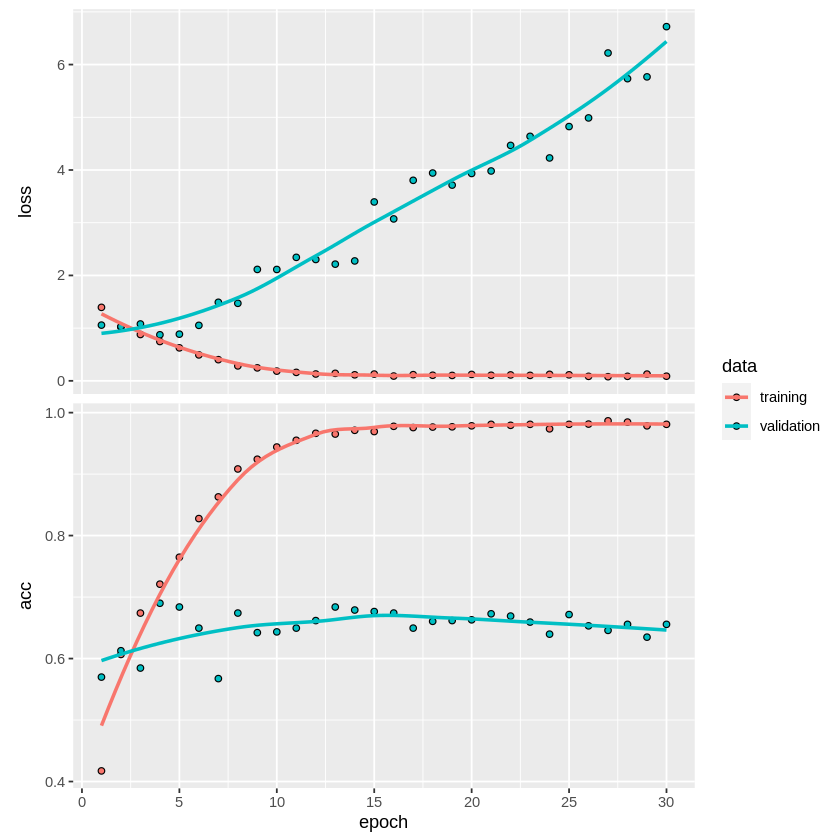

In [42]:
plot(history)

## Set up image generators 2

Here use larger images, larger batch size, and an additional model layer


In [47]:
rescale_datagen <- image_data_generator(rescale = 1/255)


train_generator2 <- flow_images_from_directory(
    "train",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)
)

validation_generator2 <- flow_images_from_directory(
    "validation",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)
)

test_generator2 <- flow_images_from_directory(
    "test",
    rescale_datagen,
    batch_size=32,
    target_size=c(256,256)

)

## Set up Model 2

In [45]:
model2 <- keras_model_sequential() %>%
    layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = "relu", input_shape = c(256,256,3)) %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_conv_2d(filters = 128, kernel_size = c(3,3), activation = "relu") %>%
    layer_max_pooling_2d(pool_size=c(2,2)) %>%
    layer_flatten() %>%
    layer_dense(units = 512, activation = "relu") %>%
    layer_dense(units = length(flowers), activation = "softmax")

# compile it
model2 %>% compile(
    loss = "categorical_crossentropy",
    optimizer = "rmsprop",
    metrics = "acc"
    )

summary(model2)

Model: "sequential_3"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_17 (Conv2D)                  (None, 254, 254, 32)            896         
________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D)     (None, 127, 127, 32)            0           
________________________________________________________________________________
conv2d_16 (Conv2D)                  (None, 125, 125, 64)            18496       
________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D)     (None, 62, 62, 64)              0           
________________________________________________________________________________
conv2d_15 (Conv2D)                  (None, 60, 60, 128)             73856       
________________________________________________________________________________
max_po

In [43]:
# first: how many images do we have?
length(dir("train", recursive = TRUE))

# 2482, and we are using a batch size of 32, so we should use
2482/32 #78 steps per epoch

# how many validation images?
length(dir("validation", recursive = TRUE)) #825
825/32 #26 validation steps

[1] 2482

[1] 77.5625

[1] 825

[1] 25.78125

In [ ]:
system.time(history2 <- model2 %>% fit(
        train_generator2,
        steps_per_epoch = 78,
        epochs = 30,
        validation_data = validation_generator2,
        validation_steps = 26))

history2

`geom_smooth()` using formula 'y ~ x'



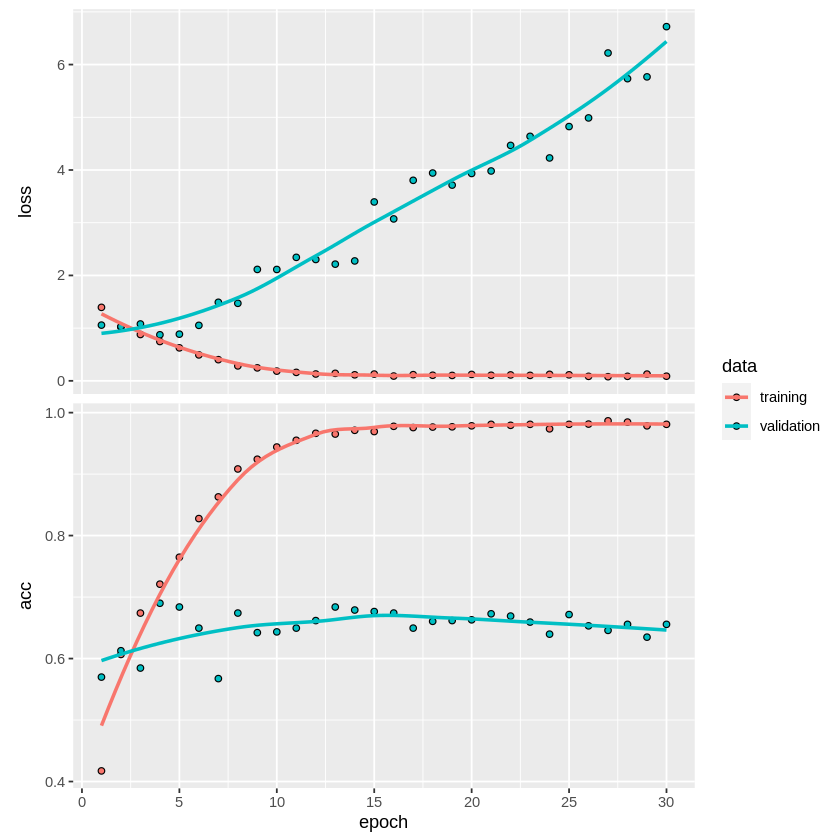

In [ ]:
plot(history2)